## TD/TP 1 : MNIST et Convolutional Neural Network
___

### 3. Notre premier notebook pour le deep learning.

#### 3. 1. Initialisation

In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121Note: you may need to restart the kernel to use updated packages.




[notice] A new release of pip available: 22.2.2 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

___
#### 3. 2. Chargement du dataset MNIST

In [4]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [5]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST("../data/raw", download=True, train=True, transform=tf), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST("../data/raw", download=True, train=False, transform=tf), batch_size=64, shuffle=True)

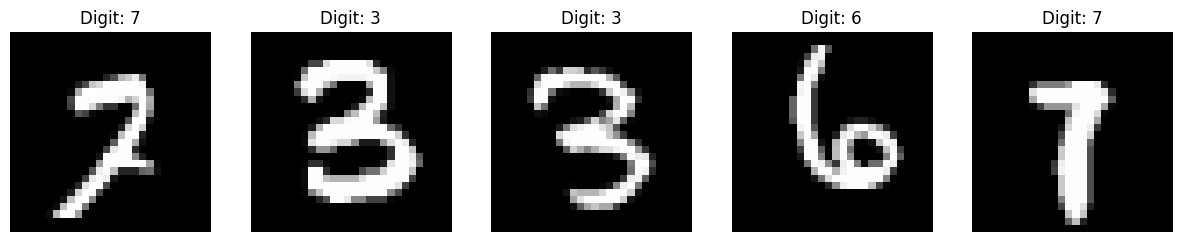

In [6]:
batch = next(iter(train_loader))
x = batch[0][:10]
y = batch[1][:10]

# Display images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(x[i].numpy().squeeze(), cmap='gray')
    axes[i].set_title(f"Digit: {y[i].item()}")
    axes[i].axis('off')

plt.show()

___
#### 3. 3. Construction d’un modèle de convolution neural network

In [7]:
class ConvNet(nn.Module):
    def __init__(self, input_size, n_kernels, output_size):
        super(ConvNet, self).__init__()
        self.net = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Second convolutional layer
            nn.Conv2d(in_channels=n_kernels, out_channels=n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Fully connected layers
            nn.Flatten(),
            # First linear layer
            nn.Linear(in_features=n_kernels * 4 * 4, out_features=50),
            nn.ReLU(),
            # Second linear layer
            nn.Linear(in_features=50, out_features=output_size)
        )

    def forward(self, x):
        return self.net(x)

# Init params
input_size = 28*28
n_kernels = 10
output_size = 10

# Create model
model = ConvNet(input_size, n_kernels, output_size)
print(model)

ConvNet(
  (net): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=160, out_features=50, bias=True)
    (8): ReLU()
    (9): Linear(in_features=50, out_features=10, bias=True)
  )
)


___
#### 3. 4. Construction du train et du test.
##### 3. 4. 1. train

In [8]:
def train(model, perm=torch.arange(0, 784).long(), n_epoch=1): # prendre en paramètre un modèle, une perm avec une valeur par défaut fixée à torch.arange(0, 784).long() et le nombre d’epoch (n_epoch) avec une valeur par défaut à 1
    # model.to(device)
    optimizer = torch.optim.AdamW(model.parameters()) # fixer un optimizer qui va ajuster automatiquement la valeur 𝛾 qui est notre learning rate
    
    model.train()  # lancer l’entraînement du modèle à l’aide de model.train()

    for epoch in range(1, n_epoch + 1): # Rédiger une boucle for représentant le nombre d’itération (epoch)
        running_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader): # Rédiger une for imbriqué représentant l’itération i qui définit la i-ème image du train_loader et un couple (data, target) représentant les valeurs de la matrice et la cible attendu.
            data, target = data.to(device), target.to(device) # Envoyer les données vers la carte graphique : data, targets = data.to(device), target.to(device)
            
            # Appliquer les permutations de pixels par la matrice circulaire de Toeplitz
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)
            
            optimizer.zero_grad() # Appliquer le step en appelant sur l’optimizer la méthode zero_grad()
            
            logits = model(data) # prédiction sur data dont le résultat sera stocké dans la variable logits
            
            loss = F.cross_entropy(logits, target) # Calculer le loss à l’aide de F.cross_entropy(), elle prends deux arguments.
            
            loss.backward() # Appliquer la mise à jour des poids sur le loss avec la méthode backward()
            
            optimizer.step() # Appliquer la méthode step() sur l’optimizer pour finaliser l’itération d’un cycle d’apprentissage.
            
            running_loss += loss.item()
            
            if batch_idx % 100 == 0: # Afficher tout les 100-itération le numéro de l’itération, le numéro du step (correspondant au numéro de l’image du train-loader) et la valeur du loss du modèle
                print(f"epoch={epoch}, step={batch_idx}: train loss={running_loss / 100:.4f}")
                running_loss = 0

##### 3. 4. 2. test

In [9]:
def test(model, perm=torch.arange(0, 784).long()):
    # D’initialiser deux variables test_loss et correct à 0.
    test_loss = 0
    correct = 0

    # model.to(device)

    model.eval()  # préparer le modèle à l’inférence.

    for data, target in test_loader: # Rédiger une for imbriqué représentant l’itération i qui définit la i-ème image du train_loader et un couple (data, target) représentant les valeurs de la matrice et la cible attendu.
        data, target = data.to(device), target.to(device) # Envoyer les données vers la carte graphique : data, targets = data.to(device), target.to(device)
            
        # permutations de pixels par la matrice circulaire de Toeplitz.
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        logits = model(data) # Lancer une prédiction à l’aide de model(date) dont le résultat sera stocké dans la variable logits.
        
        test_loss += F.cross_entropy(logits, target, reduction='sum').item() # La variable test_loss va réaliser un algorithme de type map-reduce avec les éléments de logits par rapport au targets associé à une réduction de somme. La fonction permettant cette tâche provient de F.cross_entropy() qui prend trois paramètres.
        
        pred = logits.argmax(dim=1, keepdim=True)  # La variable pred va renvoyer la prédiction finale par la probabilité la plus haute parmis les 10 éléments de sorties possible. Nous utiliserons la fonction torch.argmax() qui prends en paramètre le logits que l’on a définit, et une dim=1 pour préciser que le tableau de logits et en dimension 1.
        correct += pred.eq(target.view_as(pred)).sum().item() # La variable correct qui va compter le nombre de prédiction correcte

    # Calculer le loss et le taux d'accuracy
    test_loss = test_loss/len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    # Affichage des résultats
    print(f"\ntest loss={test_loss:.4f}, accuracy={accuracy:.4f}\n")

___
#### 3. 5. Lancement de l’entrainement

In [10]:
# Déplacement du modèle
# model.to(device)

def main(model):    
    # Affichage du nombre de paramètres du modèle
    print(f"Parameters={sum(p.numel() for p in model.parameters())/1e3}K")
    
    # Entraînement du modèle
    train(model)
    
    # Évaluation du modèle sur le dataset de test
    test(model)

In [11]:
# Définition des paramètres
n_kernels = 6
input_size = 28*28  # Taille d'entrée (nombre de canaux de l'image en niveaux de gris)
output_size = 10  # Nombre de classes de sortie (chiffres de 0 à 9)

# Initialisation du modèle ConvNet
convnets = ConvNet(input_size, n_kernels, output_size)
convnets.to(device)

# Affichage du modèle ConvNet
print("Affichage du modèle ConvNet :")
print(convnets)

# Lancement de l'entraînement et de l'évaluation
print("Lancement de l'entraînement et de l'évaluation :")
main(convnets)

Affichage du modèle ConvNet :
ConvNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=96, out_features=50, bias=True)
    (8): ReLU()
    (9): Linear(in_features=50, out_features=10, bias=True)
  )
)
Lancement de l'entraînement et de l'évaluation :
Parameters=6.422K
epoch=1, step=0: train loss=0.0233
epoch=1, step=100: train loss=1.3753
epoch=1, step=200: train loss=0.4426
epoch=1, step=300: train loss=0.3349
epoch=1, step=400: train loss=0.2884
epoch=1, step=500: train loss=0.2362
epoch=1, step=600: train loss=0.2242
epoch=1, step=700: train loss=0.2016
epoch=1, step=800: train loss=0.1615
epoch=1, step=900: train loss=0.1630

test l

___
#### 3. 6. Nouveau modèle : le perceptron multi-couches

In [12]:
class MultiPerc(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(MultiPerc, self).__init__()
        self.net = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=input_size, out_features=n_hidden),
            nn.ReLU(),
            # Second linear layer
            nn.Linear(in_features=n_hidden, out_features=n_hidden),
            nn.ReLU(),
            # Third linear layer
            nn.Linear(in_features=n_hidden, out_features=output_size),
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.net(x)

In [13]:
# Définition des paramètres
input_size = 28*28
n_hidden = 8
output_size = 8

# Initialisation du modèle MultiPerc
mlp = MultiPerc(input_size, n_hidden, output_size)
# model.to(device)
mlp.to(device)

# Affichage du modèle MultiPerc
print("Affichage du modèle MultiPerc :")
print(mlp)

# Lancement de l'entraînement et de l'évaluation
print("Lancement de l'entraînement et de l'évaluation :")
main(mlp)


Affichage du modèle MultiPerc :
MultiPerc(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
  )
)
Lancement de l'entraînement et de l'évaluation :
Parameters=6.424K


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Lancement de l'entraînement et de l'évaluation
print("Lancement de l'entraînement et de l'évaluation :")
main(mlp)

Lancement de l'entraînement et de l'évaluation :
Parameters=6.424K


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
del mlp
del convnets

___
#### 3. 7. Nouveau modèle : le perceptron multi-couches